In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("lab08.ipynb")

# Lab 8: Estimating Causal Effects via Instrumental Variables
Welcome to the 8th DS102 lab! 

The goal of this lab is to implement and get a better understanding of Instrumental Variables discussed in the lecture. IVs provide us with a way to estimate a causal effect even when the treatment itself is not randomly assigned.

The code you need to write is indicated by `...`

## Collaboration Policy
You can submit the lab in pairs (groups of two, no more than two). **If you choose to work in a pair, please make sure to add your group member on Gradescope for both written and code submission.**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually and do not share your code with anyone other than your partner**. If you do discuss the assignments with people other than your partner please **include their names** in the cell below.

`<Collaborator Name> <Collaborator e-mail>`

## Submission
**For full credit, this assignment should be completed and submitted before Wednesday, Mar 19th, 2024 at 05:00 PM PST.**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import itertools
from ipywidgets import interact, interactive

import hashlib

sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline

# Instrumental Variables Background
Suppose that we measure $Z$, the number of books a student read in the last year, and we are interested in determing how $Z$ affects an observed target outcome $Y$, the student's SAT score. The effect we are interested in is **causal** because we want to know how $Y$ changes if all randomness other than $Z$ remains fixed, and only $Z$ changes. We will refer to $Z$ as the "treatment". In general, $Z$ might be multi-dimensional, however for the purpose of this exercise we take $Z \in\mathbb{R}$.

Suppose there's also a confounder $X$, which is the income of the student's family. We don't observe $X$, but it affects both the number of books the student reads (wealthier families may have more access to books) and the student's SAT score (wealthier students may have more access to SAT tutoring).

We assume that the outcome is generated as a linear function of the confounder $X$ and treatment $Z$, with additive noise $\epsilon$:
$$Y = \beta_1 Z + \beta_2 X + \epsilon.$$

The goal is to estimate $\beta_1$, the true causal effect of the number of books a student reads on their SAT score.

### Danger of bias
As we saw in the [instrumental variable lecture note](https://docs.google.com/presentation/d/1b_-s9ZDPYvDKkmaegqP_SOspKs6vCsS-ZdIrtJEqFgA/edit#slide=id.g2c2e1ab228e_0_318), if the confounder $X$ is highly correlated with $Z$, performing ordinary least squares (OLS) on the observed data $Z$, $Y$ can lead to very biased results. Because wealthier families may have access to more books, without observing $X$ we cannot tell if correlation between $Z$ and $Y$ is due to a causal effect of reading books or is due to the higher average family income.

### Instrumental variables (IVs) and two-stage least squares (2SLS)

One way to get around this issue is by using **instrumental variables (IVs)**. A valid instrument $W$ is a variable which is independent of the confounder $X$, and affects $Y$ only through $Z$. For example, we can create such an instrument $W$ by employing *encouragement design*, where we randomly assign students to "readathons" of different durations. See the figure below for a causal diagram:

<img src="causal_diagram.png" width="400"> </img>

Using the instrumental variable $W$, we can estimate $\beta_1$ by first "guessing" $Z$ from $W$ using ordinary least squares (OLS) (denoted $\hat Z$), and then regressing $Y$ onto $\hat Z$ (instead of $Z$) using OLS as well. This procedure is known as **two-stage least squares (2SLS)**. 

In this lab, we will use a toy example with simulated data to illustrate the bias that can occur when naively performing OLS on the observed data $Z, Y$.
- In **Question 1**, we'll explore an idealized situation in which we have data about all our possible confounders.
- In **Question 2**, we'll illustrate why directly applying OLS can create biased results.
- In **Question 3**, we'll show how 2SLS can get around the drawbacks of OLS and achieve a better estimate of $\beta_1$.

# Model setup

For our toy example, suppose that we have historical data from $n=10,000$ different students with the following variables: 

$Z^{(i)} =$ number of books the student read in the last year, 

$W^{(i)} = $ duration of the "readathon" at the student's school.

$Y^{(i)} = $ the student's SAT score. 

Suppose that the student's family income $X^{(i)}$ affects both $Z^{(i)}$ and $Y^{(i)}$, but is **not observed**.

## Data Generation

The student's SAT score is linear in the number of books the student read and the student's family income:
$$Y^{(i)} = \beta_1 Z^{(i)} + \beta_2 X^{(i)} + \epsilon^{(i)}.$$ 

The number of books a student reads is linear in the duration of the readathon and the student's family income:
$$Z^{(i)} = \gamma_1 W^{(i)} + \gamma_2 X^{(i)} + \epsilon'^{(i)},$$

### The true model was generated in the following manner:
 - Sample $W^{(i)}\sim N(20,5)$    $\ \longleftarrow\ $   *Duration of Readathon for student* $i$ 
 - Sample $X^{(i)} \sim \text{Normal}(50, 10)$   $\ \longleftarrow\ $   *Income in tens of thousands (10,000) dollars for the family of student* $i$ **(unobserved variable)**
 - Generate $Z^{(i)}$ by setting $\gamma_1 = \gamma_2 =1$ and sampling a noise $\epsilon'^{(i)}\sim N(0,5)$   $\ \longleftarrow\ $  *Number of books read by student* $i$
 - Generate $Y^{(i)}$ by setting $\beta_1 = 5$, $\beta_2 = 12$  and sampling a noise $\epsilon^{(i)}\sim N(0,10)$ $\ \longleftarrow\ $  *SAT score for student* $i$.
 
**Note: The data in this lab are not observed in real life. They are instead synthetic data generated according to the procedure described above.**

## Load the data
Run the cells below to load and plot the data.

In [4]:
# Do not modify: Just run this to load the data
student_data = pd.read_csv("SAT_data.csv")
student_data.head()

,NumBooks,Income,SAT,ReadathonDuration
0,54.0,45.473122,799.0,16.0
1,71.0,53.064868,991.0,15.0
2,79.0,52.522466,1017.0,19.0
3,92.0,61.322441,1197.0,23.0
4,65.0,53.453239,982.0,12.0


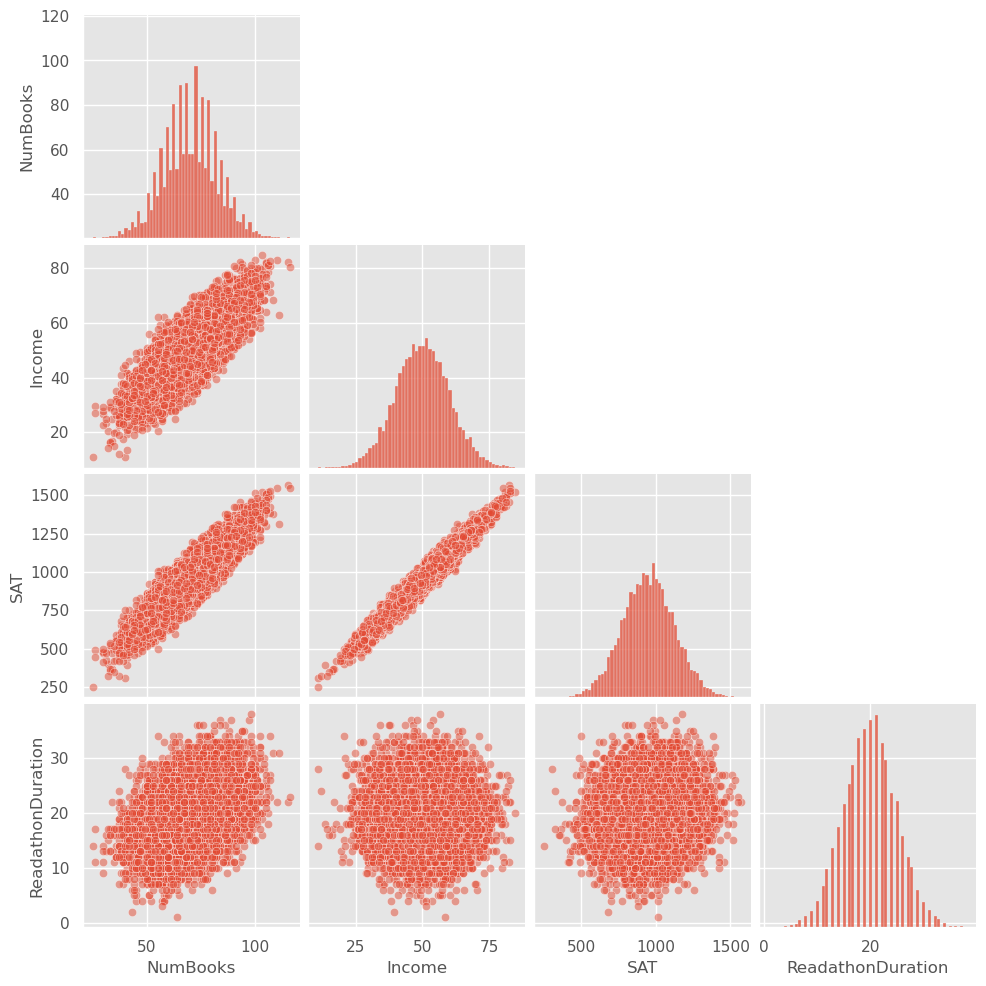

In [5]:
# make a pairplot illustrating the pairwise correlations between different columns in the dataset
fig = sns.pairplot(student_data,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

In the plot above on the main diagonal we have the histograms of each variable, and on the off-diagonals we have scatter plots illustrating the corelations between pair of variables. 

# Question 1: Understanding the Model

## 1a) Correlations between variables

Let's start our analysis by evaluating the variables in our synthetic data and the relationships between each variable.

<!-- BEGIN QUESTION -->

**Question 1a.i)** Just by inspecting the pairplot above, rank the following pairwise relationships in order from most correlated to least correlated: 
#### Z &  X, Z &  Y, Z & W, X & Y, X & W, Y & W

(Z, X) > (X,Y) > (Z, Y) > (Z,W) > (Y, W) $\approx$ (X, W)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1a.ii)** Which of the above pairs appear to be independent?

(X,W)

<!-- END QUESTION -->

## 1b) Understanding the marginal impacts

Inspect the Data Generation section above, and answer the following questions. 

<!-- BEGIN QUESTION -->

**Question 1b.i)** According to the model we used to generate our synthetic data, what is the true causal effect of an extra book read on the SAT score (i.e. if you read one more book by how much will the SAT score change)?

An increase of 5 points in SAT score per additional book read.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1b.ii)** According to the model we used to generate our synthetic data, what is the true causal effect of increasing income by \$10000 on the SAT score?

An increase of 12 points in SAT score per $10,000 increases in income.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1b.iii)** What is the true causal effect of an extra readathon day on the number of books read?

An increase of 1 book read per additional day of readathon

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1b.iv)** What is the true causal effect of increaing income by \$10000 on the number of books read?

An increase of 1 book read per $10,000 increase in income.

<!-- END QUESTION -->

## 1c) When are readathons a valid instrument?

Let's think about the conditions on readathons we would need for $W$ to be a valid instrument.

<!-- BEGIN QUESTION -->

**Question 1c.i)** What must be true about the relationship between readathons and income for $W$ to be a valid instrument? Give an example of how this might be violated.

Readathons must be independent of family income ($X$). This means schools do not assign longer readathons based on student income levels. 

If wealthier schools organize longer readathons while poorer schools have shorter ones, $W$ would be correlated with $X$ (income). In this case, the IV is invalid because part of the variation in books read ($Z$) would be due to income rather than the readathon itself. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1c.ii)** What must be true about the relationship between readathons and SAT score for $W$ to be a valid instrument? Give an example of how this might be violated?

Readathons must only influence SAT scores through books read. In other words,$W$ should not have a direct effect on $Y$ other than through $Z$ (books read).

If readathons directly improve SAT scores (not just by increasing books read), then $W$ would have a direct to $Y$, making it an invalid instrument.

<!-- END QUESTION -->

## Ordinary Least Squares
If we had access to income data $X$, then we could estimate directely $\beta_1$, $\beta_2$, $\gamma_1$, $\gamma_2$ from the data by setting up a linear regression problem and finding Ordinary Least Squares estimator. 

$$\hat\beta_1, \hat\beta_2 = \arg\min_{\beta_1, \beta_2}\Vert Y - \beta_1Z - \beta_2X \Vert_2^2$$
$$\hat\gamma_1, \hat\gamma_2 = \arg\min_{\gamma_1, \gamma_2}\Vert Z - \gamma_1W - \gamma_2X \Vert_2^2$$

To find OLS estimators we will use [`sm.OLS`](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html?highlight=ols) from `statsmodels.api`.

In [6]:
# No TODOs here: Just examine the code
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [7]:
# Computing the OLS estimators for gamma_1 and gamma_2
gammas_model = fit_OLS_model(student_data, 'NumBooks', ['ReadathonDuration', 'Income'])
print(gammas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:               NumBooks   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          9.849e+05
Date:                Sun, 16 Mar 2025   Prob (F-statistic):                        0.00
Time:                        07:35:04   Log-Likelihood:                         -30390.
No. Observations:               10000   AIC:                                  6.078e+04
Df Residuals:                    9998   BIC:                                  6.080e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [8]:
# Print the fitted_estimators
gammas = gammas_model.params
print("The estimated causal effect on number of books read of an additional Readathon day is {:.2f}".format(gammas[0]))
print("The estimated causal effect on number of books read of an additional $10000 is {:.2f}".format(gammas[1]))
# The numbers you get should be very close to you answer in 1.b

The estimated causal effect on number of books read of an additional Readathon day is 1.00
The estimated causal effect on number of books read of an additional $10000 is 1.00


## 1d) Estimate causal effect of `NumBooks` and `Income` on the SAT Score

Fill in the code below (similar as above) to estimate the causal effect of `NumBooks` and `Income` on the SAT Scores. 

In [9]:
# Compute OLS estimators for beta_1 and beta_2
betas_model = fit_OLS_model(student_data, 'SAT', ['NumBooks', 'Income'])
print(betas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    SAT   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.546e+07
Date:                Sun, 16 Mar 2025   Prob (F-statistic):                        0.00
Time:                        07:35:04   Log-Likelihood:                         -37348.
No. Observations:               10000   AIC:                                  7.470e+04
Df Residuals:                    9998   BIC:                                  7.471e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [10]:
grader.check("q1d")

q1d results: All test cases passed!

In [11]:
# Print the fitted_estimators
betas = betas_model.params
print("The estimated causal effect on SAT score of an additional book read is {:.2f}".format(betas['NumBooks']))
print("The estimated causal effect on SAT score of an additional $10000 is {:.2f}".format(betas['Income']))
# The numbers you get should be very close to you answer in 1.b

The estimated causal effect on SAT score of an additional book read is 4.98
The estimated causal effect on SAT score of an additional $10000 is 12.03


## Summing up Question 1

In Question 1, we saw how we can estimate all causal relationships if we have access to the income variable. This mirrors an idealized world where we have data for *every possible confounder*: if we knew this information for every individual/observation in our data, we could trivially calculate the causal effect of interest.

However, in reality, we almost never have complete access to data on our confounding variables. What do we do then? 

**Our next goal**: For the following two questions, we will mirror this reality by attempting to estimate the true causal effect of the number of books a student reads on their SAT score **without access** to the Income variable.

# Question 2: Naive OLS on the observed variables $Z$, $Y$.
In class, we've discussed the [dangers of blindly using observational data to establish causality](https://data102.datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fds-102%2Ffa23-materials&urlpath=tree%2Ffa23-materials%2Flecture%2Flecture15%2F01_association_correlation_causation.ipynb&branch=main). Here, we'll demonstrate this in a more concrete manner by naively attempting to estimate the causal effect $\beta_1$ by using plain linear regression (OLS) on the observed variables $Z$ and $Y$. This time we will include an intercept term:

$$\hat\beta_1, \hat c = \arg\min_{\beta_1, c} \Vert Y - \beta_1Z - c \Vert^2_2$$

## 2.a) Fit Naive OLS
Fill in the code below to fit the OLS model described above.

In [12]:
# Fit OLS parameters to predict Y from Z.
beta_naive_model = fit_OLS_model(student_data, 'SAT', ['NumBooks'], intercept=True)
print(beta_naive_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SAT   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                 5.117e+04
Date:                Sun, 16 Mar 2025   Prob (F-statistic):               0.00
Time:                        07:35:04   Log-Likelihood:                -56726.
No. Observations:               10000   AIC:                         1.135e+05
Df Residuals:                    9998   BIC:                         1.135e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.8488      4.074     10.518      0.0

In [13]:
grader.check("q2a")

q2a results: All test cases passed!

In [14]:
print("The Naive OLS estimate of beta_1 is {:.2f}, while the true beta_1 is {}".format(beta_naive_model.params[1], 5))

The Naive OLS estimate of beta_1 is 12.96, while the true beta_1 is 5


<!-- BEGIN QUESTION -->

## 2.b) Does the Naive approach overestimate or under estimate the value of reading books?

*Hint: Answer this question by comparing the naive estimate and the true value of $\beta_1$*

The naive OLS estimate of $\beta_1$ is 12.96, but the true effect of reading an additional book on SAT scores is only 5. This means the OLS estimate is biased upwards due to the omitted variable (income). There are a couple of reasons that can explain why the naive estimate is biased. First, students who read more books tend to come from wealthier families. Also, wealthier families provide additional SAT advantages, such as tutoring and better schools. Since we didn't include income ($X$) in the regression, our regresssion absorbs this extra effect, inflating the coefficient.

<!-- END QUESTION -->

# 3. Instrumental variables and 2SLS

Clearly, using OLS on observational data without confounders is not a valid way to estimate causal effects.

To eliminate bias, a better solution is to utilize a method called **Two-stage least squares regression (2SLS)** in conjunction with an **instrumental variable**.

The process proceeds in two parts:
1. In the first stage, we "predict" the number of books a student read from whether or not they had a readathon, $W$, producing an estimate $\hat{Z}$.
2. Then, in the second stage, we regress the SAT score $Y$ onto the predicted number of books read $\hat{Z}$.

## 3a) Stage 1: Predict treatment variable $\hat{Z}$ from instrumental variable $W$

### 3a.i) Fitting the model

Complete the code below to fit an OLS model that predicts $\hat{Z}$ (estimated number of books read) using $W$ (whether they had a readathon).

$$\hat\gamma_1, \hat c = \arg\min_{\gamma_1, c} \Vert Z - \gamma_1W - c\Vert_2^2$$

In [15]:
# Fit OLS parameters to predict Z from W
gamma1_model = fit_OLS_model(student_data, 'NumBooks', ['ReadathonDuration'], intercept=True)
print(gamma1_model.summary())

                            OLS Regression Results                            
Dep. Variable:               NumBooks   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     1927.
Date:                Sun, 16 Mar 2025   Prob (F-statistic):               0.00
Time:                        07:35:07   Log-Likelihood:                -38391.
No. Observations:               10000   AIC:                         7.679e+04
Df Residuals:                    9998   BIC:                         7.680e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                50.1628      0.46

In [16]:
grader.check("q3a_i")

q3a_i results: All test cases passed!

In [17]:
print("The OLS estimate of gamma_1 is {:.3f}, while the true gamma_1 is {}".format(gamma1_model.params[1], 1))

The OLS estimate of gamma_1 is 0.996, while the true gamma_1 is 1


<!-- BEGIN QUESTION -->

### 3a.ii) Understanding the first stage

We observe that the estimate of $\gamma_1$ above is very close to the true value, even though we don't make use of the `Income` variable. How can you explain this?

*Hint: Think about independence, and how the relationship between X and Z might be affected by the relationship between W and Z.*

The key reason why are estimate is accurate even though we didn't include Income($X$) is because ReadathonDuration($W$) is independent of Income ($X$). Since $W$ is not correlated with income, its provides a clean measure of its effects on books read. Normally if $X$ (Income) influences $Z$(Books Read) and we omit it, our regression could be biased. Again $W$ is independent of $X$, so it's on $Z$ is isolated.

<!-- END QUESTION -->

### 3a.iii) (OPTIONAL - NOT GRADED) 

We just saw that the estimate for $\gamma_1$ is unbiased for the true value with only $W$. Back in Question 1 we also did a regression to get $\gamma_1$ where we included both $W$ and $X$ as regressors. What additional benefit does including $X$ give for estimating $\gamma_1$?

_Type your answer here, replacing this text._

## Getting ready for Stage 2

Now we can use the OLS model above to create $\hat Z$ predictions that we'll need in stage 2!

In [18]:
# Compute predictions for number of books read
intercept_OLS = gamma1_model.params[0]
gamma1_OLS = gamma1_model.params[1]
Z_hat = intercept_OLS + gamma1_OLS*student_data['ReadathonDuration']

# Add the predictions to the student_data dataframe
student_data['PredictedNumBooks'] = Z_hat
student_data.head()

,NumBooks,Income,SAT,ReadathonDuration,PredictedNumBooks
0,54.0,45.473122,799.0,16.0,66.104173
1,71.0,53.064868,991.0,15.0,65.107836
2,79.0,52.522466,1017.0,19.0,69.093186
3,92.0,61.322441,1197.0,23.0,73.078536
4,65.0,53.453239,982.0,12.0,62.118823


## 3b) Stage 2: Estimate target $Y$ from predicted treatment variable $\hat{X}_1$
Complete the code below to fit an OLS model that predicts $Y$ (SAT score) using $Z_hat$ (estimated number of books read).
$$\hat \beta_1, \hat c = \arg\min_{\beta_1, c}\Vert Y-\beta_1\hat Z - c\Vert_2^2$$

In [19]:
# Fit OLS parameters to predict Y from the predicted Z_hat.
beta1_model = fit_OLS_model(student_data, "SAT", ["PredictedNumBooks"], intercept=True)
print(beta1_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SAT   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     191.8
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           3.24e-43
Time:                        07:36:39   Log-Likelihood:                -65687.
No. Observations:               10000   AIC:                         1.314e+05
Df Residuals:                    9998   BIC:                         1.314e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               611.8673     24.51

In [20]:
grader.check("q3b")

q3b results: All test cases passed!

In [21]:
print("The 2SLS estimate of beta_1 is {:.3f}, while the true value is {}".format(beta1_model.params[1], 5))

The 2SLS estimate of beta_1 is 4.835, while the true value is 5


## 3.c) Conceptual Questions

<!-- BEGIN QUESTION -->

#### 3.c.i) Which technique produced a better estimate of $\beta_1$, naive OLS or 2SLS?

Naive OLS estimated $\beta_1$ at 12.96, which is much higher than the true value of 5.00. This overestimation occurred because OLS did not control for income, which is a confounding variable that effects both books read and SAT scores. 2SLS estimated $beta_1$ as 4.835, which is very close to the true value of 5.00. This is because 2SLS removes the bias caused by confounding variables like income by using Readathon as an instrument. Since 2SLS correctly isolates the causal effect, it provides a more accurate and unbiased estimate of $\beta_1$ than naive OLS.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### 3.c.ii) Qualitatively, how would you describe the predictions $\hat Z$? How do they compare to the original $Z$? What sources of variation do they remove?

*Hint: If it helps to see the predicted and original values, you can look at the dataframe `student_data` or look at the snippet above printed out right before Stage 2.*

Predicted $\hat{Z}$ values are less variable than the original $Z$ values because they are estimated using only the instrumental variable (ReadathonDuration). $\hat{Z}$ removies variaion in $Z$ that is due to confounders like income. The only variation that remains in $\hat{Z}$ is the part of books read that is explained by readathons, which is independent of income. Thus, by regressing SAT scores on $\hat{Z}$ instead of $Z$, we ensure that our estimate of $\beta_1$ is not biased by omitted counfounders.

<!-- END QUESTION -->

## Congratulations! You have finished Lab 8!

You've reached the end of the lab!

Before you submit to Gradescope, make sure you pass all the autograded portions of this lab. **Run the cell below to generate a PDF of your lab submission**, and **run the last cell to generate a zip file of your lab submission.** Do **not** create your lab PDF by exporting your notebook to a PDF.

To submit your lab to Gradescope, submit the PDF to Lab 8 Written and the zip file to Lab 8 Code.

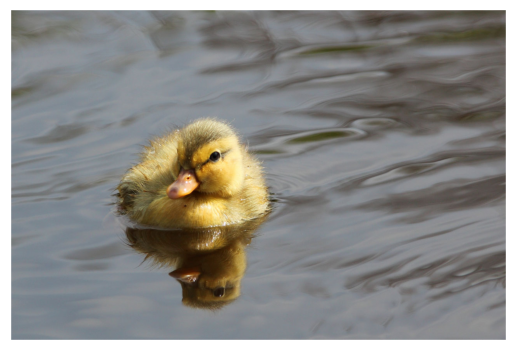

In [22]:
import matplotlib.image as mpimg
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("lab08.ipynb", filtering=True, pagebreaks=True)
if(path.exists('lab08.pdf')):
    img = mpimg.imread('floof.jpg')
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()
    display(HTML("Download your PDF <a href='lab08.pdf' download>here</a>."))

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [23]:
grader.check_all()

q1d results: All test cases passed!

q2a results: All test cases passed!

q3a_i results: All test cases passed!

q3b results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [ ]:
grader.export(pdf=False, force_save=True)

<IPython.core.display.Javascript object>